# Setup

In [98]:
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as sqlio
import statsmodels.formula.api as smf
import imp

In [99]:
import queries
import functions as f

In [101]:
pd.set_option('precision', 2) 
pd.set_option('display.width', 200)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Obtaining and cleaning the data

In [4]:
conn = psycopg2.connect(f.CONNSTRING)

In [7]:
df = sqlio.read_sql_query(queries.q_rating, conn) 

In [8]:
df['difference'] = df.rating_own - df.rating_opponent 
df['result'] = df.win + 0.5 * df.draw

In [9]:
df['d_g'] = round(df.difference / 200)
d_g_max = 3
df.loc[df.d_g < -d_g_max, 'd_g'] = -d_g_max
df.loc[df.d_g > d_g_max, 'd_g'] = d_g_max

df['e_g'] = round(df.ev / 100)

In [10]:
means = pd.DataFrame(df.query('-3 <= e_g <= 3').groupby(['d_g', 'e_g']).result.mean())
counts = df.query('-3 <= e_g <= 3').groupby(['d_g', 'e_g']).result.count()
means['counts'] = counts  
means = means.query('counts >= 10 and d_g >= 0')
del means['counts']

In [50]:
table = means.unstack(0)   
table.index = [int(v) for v in table.index]
def group_name(v):
    return '%s to %s' % (v*200-100, v*200+100)
table.columns = [group_name(v) for v in table.columns.get_level_values(1)]

In [55]:
table

,-100.0 to 100.0,100.0 to 300.0,300.0 to 500.0,500.0 to 700.0
-3,NaN,0.19,0.54,NaN
-2,NaN,0.30,0.41,0.52
-1,0.24,0.51,0.61,0.74
0,0.45,0.69,0.81,0.79
1,0.76,0.82,0.93,0.93
2,0.87,0.91,0.97,0.96
3,1.00,0.97,0.96,0.99


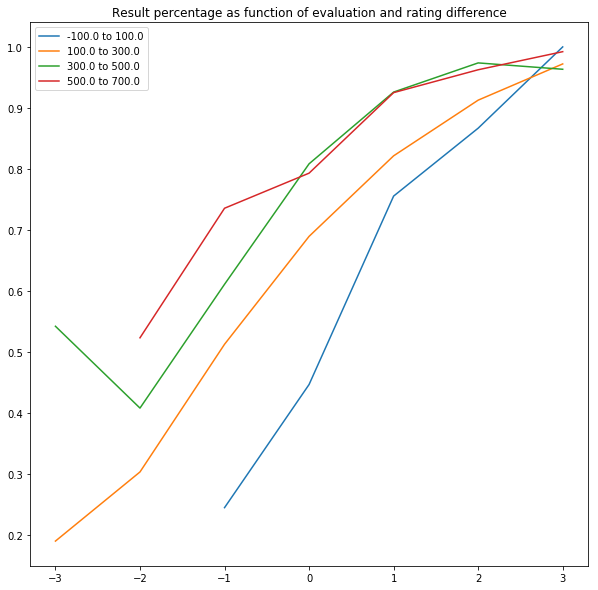

In [100]:
settings = {
    'title': "Result percentage as function of evaluation and rating difference",
    'legend': True, 
    'figsize': (10, 10)
}
table.plot(**settings)

The graph shows the expected result percentage as a function of the position evaluation and the rating difference to the opponent.

For instance, we find that, if you play against someone who is 400 points lower-rated then you and your evaluation is -2, then you are still obtaining more than 50% of the points! 

## Quantifying the rating-evaluation tradeoff
We know try to quantify these effects and calculate the tradeoff between player rating and the position evaluation. We do this using a linear regression.

Creating helper variables that are scaled, which gives us nicer regression coefficients.

In [102]:
df['rating_own_small'] = df.rating_own / 100
df['rating_opponent_small'] = df.rating_opponent / 100
df['diff_small'] = df.difference / 100
df['eval_small'] = df.ev / 100

In [103]:
reg = smf.ols('result ~ eval_small + diff_small', data=df.query('-5 <= eval_small <= 5')).fit()
params = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                 1.012e+04
Date:                Tue, 10 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:56:30   Log-Likelihood:                -5863.9
No. Observations:               22262   AIC:                         1.173e+04
Df Residuals:                   22259   BIC:                         1.176e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5085      0.002    240.728      0.000       0.504       0.513
eval_small     0.0962      0.002     61.537      0.000       0.093       0.099
diff_small     0.0679      0.001     94.528      0.000       0.066       0.069
==============================================================================
Omnibus:                        3.146   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                3.154
Skew:                           0.023   Prob(JB):                        0.207
Kurtosis:                       2.964   Cond. No.                         3.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
value_of_100_rating = params['diff_small'] / params['eval_small']

In [105]:
df_value = pd.DataFrame()
df_value['rating_difference'] = np.arange(0, 400, 100)
df_value['evaluation'] = -(df_value.rating_difference * value_of_100_rating)/100

### Required evaluation to get result of 50% against a player

In [106]:
df_value.set_index('rating_difference')

,evaluation
rating_difference,
0,-0.00
100,-0.71
200,-1.41
300,-2.12
